In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, re, os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor

In [22]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [23]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [24]:
chdir = True

In [25]:
import itertools
marker = itertools.cycle(('x',',', '+', '.', 'o', '*'))
cycol = itertools.cycle('bgrcmk')

# Service chain configuration

In [26]:
from IPython.display import IFrame
IFrame("../assets/testbed.png", width=850, height=480)

In [27]:
current_dir = os.getcwd()
file_path = os.path.abspath('../linear/datasets/load_stimulus_global.csv')
#file_path = os.path.abspath('../linear/datasets/random_rates_exp-1.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
#data = data.drop('latency', axis=1)
df = data.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1780 entries, 0 to 177
Data columns (total 63 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   input_rate                          1780 non-null   float64
 1   output_rate                         1780 non-null   float64
 2   latency                             1780 non-null   float64
 3   firewall_instructions               1780 non-null   float64
 4   nf_router_instructions              1780 non-null   float64
 5   ndpi_stats_instructions             1780 non-null   float64
 6   payload_scan_instructions           1780 non-null   float64
 7   bridge_instructions                 1780 non-null   float64
 8   firewall_branches                   1780 non-null   float64
 9   nf_router_branches                  1780 non-null   float64
 10  ndpi_stats_branches                 1780 non-null   float64
 11  payload_scan_branches               1780 non

In [28]:
corr = data.corr()
correlation_list = []
for i in range(1, 2):
    for j in range(i+1, len(corr.columns)):
        correlation_list.append((corr.columns[i], corr.columns[j], abs(corr.iloc[i, j])))


sorted_correlations = sorted(correlation_list, key=lambda x: x[2], reverse=True)

for correlation in sorted_correlations:
    print(f"Correlation between {correlation[0]} and {correlation[1]}: {correlation[2]:.2f}")

Correlation between output_rate and ndpi_stats_LLC-loads: 0.98
Correlation between output_rate and ndpi_stats_L1-dcache-load-misses: 0.98
Correlation between output_rate and ndpi_stats_cache-references: 0.98
Correlation between output_rate and payload_scan_LLC-loads: 0.98
Correlation between output_rate and payload_scan_cache-references: 0.97
Correlation between output_rate and nf_router_LLC-loads: 0.97
Correlation between output_rate and payload_scan_L1-dcache-load-misses: 0.97
Correlation between output_rate and firewall_LLC-stores: 0.97
Correlation between output_rate and nf_router_cache-references: 0.97
Correlation between output_rate and nf_router_L1-dcache-load-misses: 0.97
Correlation between output_rate and firewall_cache-references: 0.97
Correlation between output_rate and bridge_LLC-stores: 0.97
Correlation between output_rate and ndpi_stats_LLC-stores: 0.97
Correlation between output_rate and firewall_L1-dcache-load-misses: 0.97
Correlation between output_rate and firewall_L

In [29]:
corr = data.corr()
correlation_list = []
for i in range(2,3):
    for j in range(i+1, len(corr.columns)):
        correlation_list.append((corr.columns[i], corr.columns[j], abs(corr.iloc[i, j])))


sorted_correlations = sorted(correlation_list, key=lambda x: x[2], reverse=True)

for correlation in sorted_correlations:
    print(f"Correlation between {correlation[0]} and {correlation[1]}: {correlation[2]:.2f}")

Correlation between latency and ndpi_stats_LLC-loads: 0.59
Correlation between latency and ndpi_stats_cache-references: 0.58
Correlation between latency and ndpi_stats_L1-dcache-load-misses: 0.57
Correlation between latency and payload_scan_LLC-loads: 0.57
Correlation between latency and firewall_LLC-loads: 0.56
Correlation between latency and firewall_cache-references: 0.56
Correlation between latency and firewall_L1-dcache-load-misses: 0.56
Correlation between latency and payload_scan_cache-references: 0.56
Correlation between latency and nf_router_LLC-loads: 0.56
Correlation between latency and payload_scan_L1-dcache-load-misses: 0.56
Correlation between latency and firewall_LLC-stores: 0.56
Correlation between latency and nf_router_L1-dcache-loads: 0.56
Correlation between latency and nf_router_instructions: 0.55
Correlation between latency and nf_router_branches: 0.55
Correlation between latency and nf_router_cache-references: 0.55
Correlation between latency and nf_router_L1-dcac

# DNN to predict rate (training set: global)

In [30]:
current_dir = os.getcwd()
file_path = os.path.abspath('../linear/datasets/load_stimulus_global.csv')
#file_path = os.path.abspath('../linear/datasets/random_rates_exp-1.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
#data = data.drop('latency', axis=1)
df = data.dropna()

In [31]:
# data set
# load_stimulus_global.csv: exp1_exp10
# load_stimulus_global_1.csv:exp1_exp10+fixed_5000+fixed_7500
# load_stimulus_global_2.csv:exp1_exp10+fixed_5000+fixed_7500+random
# load_stimulus_global_3.csv:exp1_exp10+random
#load_stimulus_global_4.csv:exp1_exp10+stage_random
# performance: global>3>2>1

In [32]:
# training 
X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
#X = df.drop(['input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
  #           'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
  #           'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
    #         'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
      #       'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X=df.drop(['input_rate','output_rate', 'latency','ndpi_stats_branch-load-misses',
            'payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
             'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
             'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
            'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses','ndpi_stats_branches','firewall_branches','payload_scan_branches','bridge_branches'], axis=1)

y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

column_order = X_train.columns
X_test = X_test[column_order]


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(y))

1780


In [33]:
# model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))

# Add output layer
model.add(Dense(1))

In [34]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=8, epochs=100, verbose=1)

Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 13096738.0000
Epoch 2/100
156/156 [==============================] - 1s 3ms/step - loss: 2295606.7500
Epoch 3/100
156/156 [==============================] - 1s 3ms/step - loss: 776741.6250
Epoch 4/100
156/156 [==============================] - 1s 4ms/step - loss: 405643.1875
Epoch 5/100
156/156 [==============================] - 1s 4ms/step - loss: 317608.0938
Epoch 6/100
156/156 [==============================] - 1s 4ms/step - loss: 282426.7500
Epoch 7/100
156/156 [==============================] - 0s 3ms/step - loss: 261207.0312
Epoch 8/100
156/156 [==============================] - 0s 3ms/step - loss: 258156.8594
Epoch 9/100
156/156 [==============================] - 1s 3ms/step - loss: 242486.8594
Epoch 10/100
156/156 [==============================] - 1s 3ms/step - loss: 231920.7500
Epoch 11/100
156/156 [==============================] - 0s 3ms/step - loss: 231742.0938
Epoch 12/100
156/156 [================

17/17 [==============================] - 0s 2ms/step
[0.0, 76.40449438202246, 87.26591760299625, 94.00749063670412, 95.50561797752809, 97.37827715355806, 97.56554307116106, 97.75280898876404, 98.12734082397003, 98.50187265917603, 99.06367041198502]


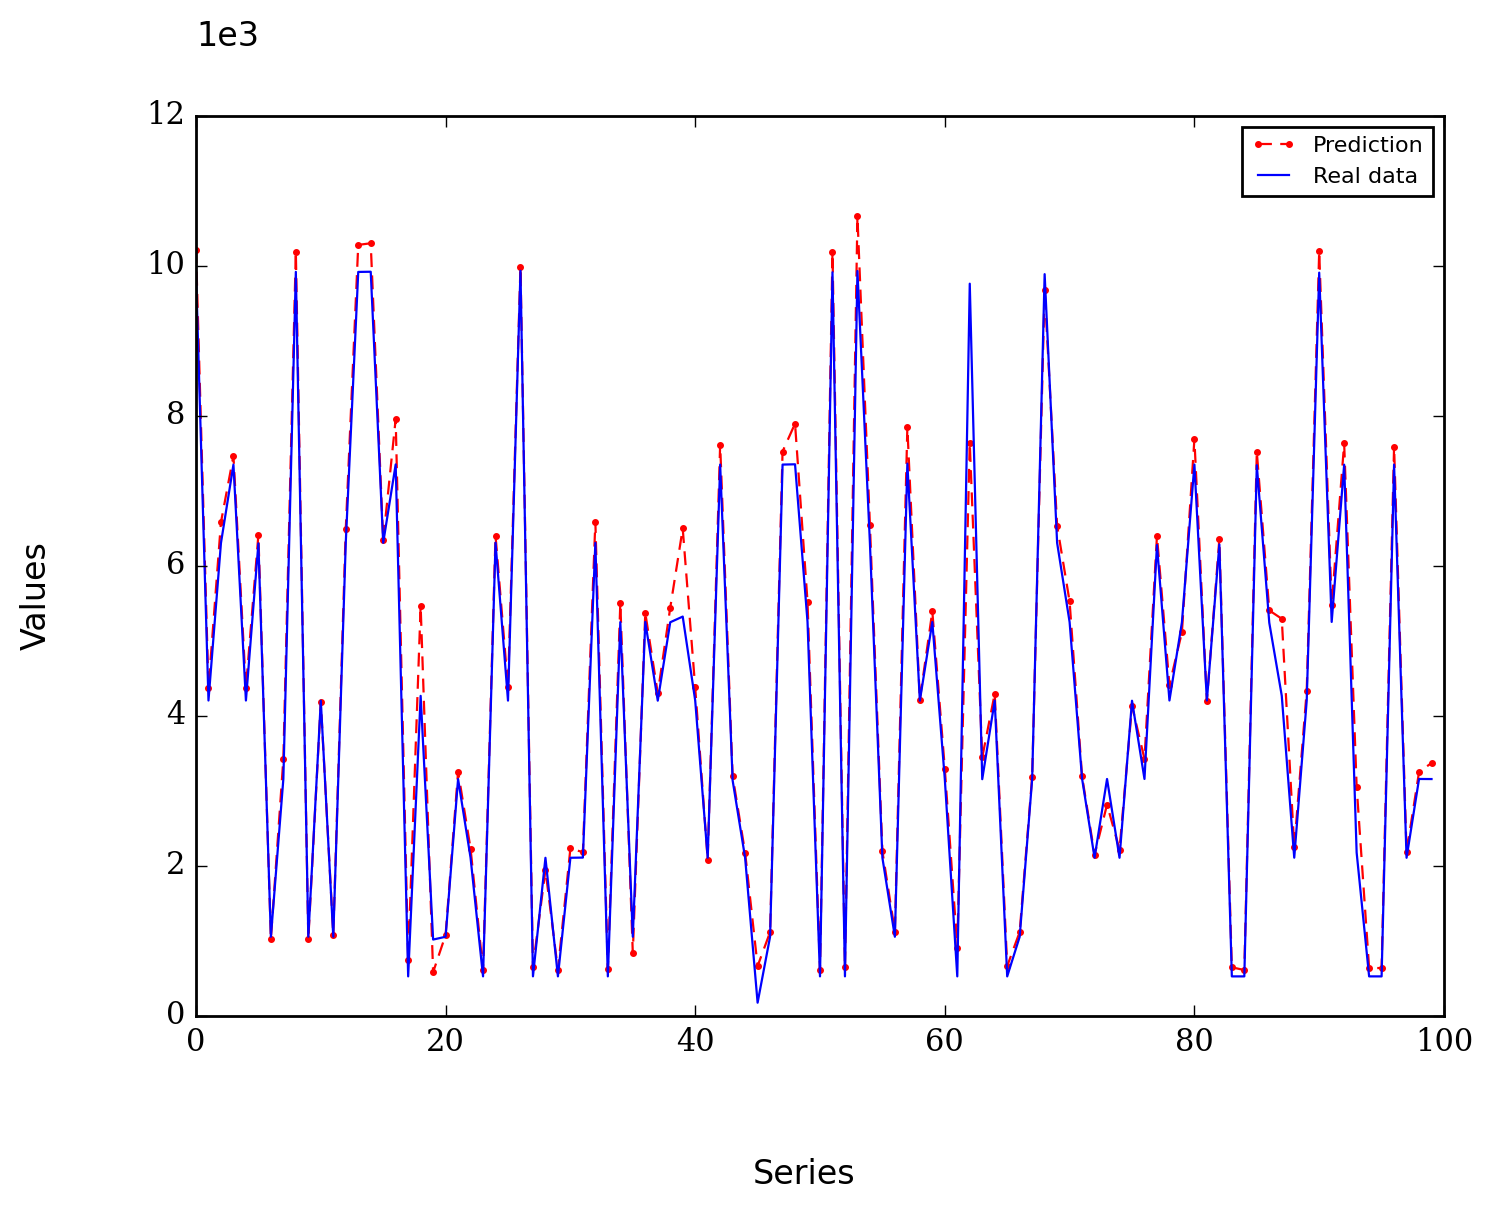

In [35]:
# Make predictions on the test set
import matplotlib.ticker as mticker

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# accuracy
threshold = 0.05  
y_pred=np.array(y_pred)
y_pred = [item for subset in y_pred for item in subset]
y_test=np.array(y_test)
distances = [abs(real - pred) / real for real, pred in zip(y_test, y_pred)]
accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100
accuracy_cdf=[]
# plot cdf of accurancy
for threshold in range(11):
    threshold = threshold/10
    distances = [abs(real - pred) / real for real, pred in zip(y_test, y_pred)]
    accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100
    accuracy_cdf.append(accuracy_within_threshold)
print(accuracy_cdf)

# plot

fig, ax = plt.subplots(facecolor='white', figsize=(8,6))
#ax.set_facecolor('white')
plt.style.use('classic')

plt.plot(y_pred[0:100], marker='o',c='r',markersize = 2, linewidth = 0.8, linestyle='-', markeredgecolor='red', dashes=(5, 3),label='Prediction')
plt.plot(y_test.tolist()[0:100], c='b',linestyle='-',linewidth = 0.8,label='Real data')


plt.legend(loc="upper right", fontsize=8)
fig.text(0.5, 0.01, 'Series', size='12', ha='center')
fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
#plt.grid()
ax.set_facecolor('white')

# Set y-axis tick format
formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}")
ax.yaxis.set_major_formatter(formatter)
# Set text in the upper left corner of the figure
fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')


plt.show()


In [36]:

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.9792141574891883


# XAI: Analyze Sensitivity

In [37]:
import numpy as np
import tensorflow as tf

# Get the predictions for X_test
y_pred = model.predict(X_test)

# Calculate gradients with respect to each feature
gradients = []
for i in range(X_test.shape[0]):
    input_instance = tf.convert_to_tensor(X_test[i].reshape(1, -1))
    with tf.GradientTape() as tape:
        tape.watch(input_instance)
        output_instance = model(input_instance)
    gradient = tape.gradient(output_instance, input_instance)
    gradients.append(gradient.numpy())

# Calculate the absolute average gradient for each feature
avg_gradients = np.abs(np.mean(np.array(gradients), axis=0))

# Perform min-max normalization on the gradients
min_gradient = np.min(avg_gradients)
max_gradient = np.max(avg_gradients)
normalized_gradients = (avg_gradients - min_gradient) / (max_gradient - min_gradient)
normalized_gradients =normalized_gradients[0]
print(normalized_gradients)
# Convert the normalized_gradients vector to a pandas Series with feature names as index
sensitivity_series = pd.Series(normalized_gradients, index=column_order)

# Convert the Series to a dictionary
sensitivity_dict = sensitivity_series.to_dict()

print(sensitivity_dict)


17/17 [==============================] - 0s 1ms/step
[0.06647537 0.14219122 0.30899436 0.03894    0.17849718 0.27186223
 0.42885936 0.07540471 0.07284138 0.01006542 0.05688954 0.03016463
 0.57917383 0.15889859 0.79104064 0.21650543 0.52672889 1.
 0.11482666 0.25664516 0.19130909 0.10902065 0.73008021 0.36843139
 0.65440943 0.10740794 0.63069083 0.58670477 0.1758911  0.02275286
 0.         0.11985471 0.15761692 0.20398482 0.09672241 0.01303983
 0.26469669 0.46332274 0.73895765 0.66181173 0.84395087]
{'firewall_instructions': 0.06647537295050418, 'nf_router_instructions': 0.14219121796361756, 'ndpi_stats_instructions': 0.308994358976176, 'payload_scan_instructions': 0.03894000253085057, 'bridge_instructions': 0.17849717710514598, 'nf_router_branches': 0.27186223468524306, 'ndpi_stats_branch-misses': 0.428859357334552, 'firewall_branch-load-misses': 0.07540470823648857, 'bridge_branch-load-misses': 0.07284137998690621, 'payload_scan_cache-misses': 0.010065418861988881, 'firewall_cache-ref

# shap

In [38]:
#LIME (Local Interpretable Model-agnostic Explanations)

In [39]:
import shap

# Create a function to predict the output of the model
predict_fn = lambda x: model.predict(x)

# Create a SHAP explainer with the permutation method
explainer = shap.Explainer(predict_fn, X_train, algorithm="permutation")

# Calculate SHAP values for a subset of the test data
num_samples = 100  # You can adjust this value to make it smaller
shap_values = explainer.shap_values(X_test[:num_samples])


132/132 [==============================] - 0s 2ms/step


Permutation explainer:   4%|██▋                                                                | 4/100 [00:00<?, ?it/s]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:   6%|███▌                                                       | 6/100 [00:16<02:35,  1.65s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:   7%|████▏                                                      | 7/100 [00:19<03:39,  2.36s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:   8%|████▋                                                      | 8/100 [00:23<04:17,  2.80s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:   9%|█████▎                                                     | 9/100 [00:26<04:36,  3.04s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  10%|█████▊                                                    | 10/100 [00:30<04:42,  3.14s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  11%|██████▍                                                   | 11/100 [00:33<04:54,  3.30s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  12%|██████▉                                                   | 12/100 [00:38<05:17,  3.61s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  13%|███████▌                                                  | 13/100 [00:41<04:57,  3.41s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  14%|████████                                                  | 14/100 [00:44<05:01,  3.50s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  15%|████████▋                                                 | 15/100 [00:48<05:14,  3.70s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  16%|█████████▎                                                | 16/100 [00:52<05:19,  3.80s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  17%|█████████▊                                                | 17/100 [00:56<05:14,  3.79s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  18%|██████████▍                                               | 18/100 [01:00<05:10,  3.79s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  19%|███████████                                               | 19/100 [01:05<05:28,  4.05s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  20%|███████████▌                                              | 20/100 [01:09<05:27,  4.10s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  21%|████████████▏                                             | 21/100 [01:12<05:04,  3.86s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  22%|████████████▊                                             | 22/100 [01:16<05:04,  3.91s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  23%|█████████████▎                                            | 23/100 [01:20<05:01,  3.91s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  24%|█████████████▉                                            | 24/100 [01:23<04:41,  3.71s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  25%|██████████████▌                                           | 25/100 [01:27<04:27,  3.56s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  26%|███████████████                                           | 26/100 [01:30<04:18,  3.49s/it]

132/132 [==============================] - 1s 9ms/step


Permutation explainer:  27%|███████████████▋                                          | 27/100 [01:35<04:55,  4.05s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  28%|████████████████▏                                         | 28/100 [01:39<04:54,  4.10s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  29%|████████████████▊                                         | 29/100 [01:42<04:28,  3.78s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  30%|█████████████████▍                                        | 30/100 [01:48<04:58,  4.27s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  31%|█████████████████▉                                        | 31/100 [01:53<05:01,  4.37s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  32%|██████████████████▌                                       | 32/100 [01:58<05:12,  4.59s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  33%|███████████████████▏                                      | 33/100 [02:03<05:13,  4.68s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  34%|███████████████████▋                                      | 34/100 [02:07<04:57,  4.50s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  35%|████████████████████▎                                     | 35/100 [02:12<05:10,  4.77s/it]

132/132 [==============================] - 0s 906us/step


Permutation explainer:  36%|████████████████████▉                                     | 36/100 [02:17<05:08,  4.83s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  37%|█████████████████████▍                                    | 37/100 [02:21<04:44,  4.52s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  38%|██████████████████████                                    | 38/100 [02:26<04:46,  4.62s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  39%|██████████████████████▌                                   | 39/100 [02:29<04:24,  4.33s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  40%|███████████████████████▏                                  | 40/100 [02:33<04:09,  4.15s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  41%|███████████████████████▊                                  | 41/100 [02:37<03:55,  4.00s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  42%|████████████████████████▎                                 | 42/100 [02:41<03:54,  4.04s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  43%|████████████████████████▉                                 | 43/100 [02:46<04:04,  4.28s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  44%|█████████████████████████▌                                | 44/100 [02:49<03:44,  4.01s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  45%|██████████████████████████                                | 45/100 [02:54<03:52,  4.23s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  46%|██████████████████████████▋                               | 46/100 [02:56<03:24,  3.78s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  47%|███████████████████████████▎                              | 47/100 [03:01<03:29,  3.95s/it]

132/132 [==============================] - 0s 975us/step


Permutation explainer:  48%|███████████████████████████▊                              | 48/100 [03:03<03:01,  3.50s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  49%|████████████████████████████▍                             | 49/100 [03:06<02:52,  3.38s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  50%|█████████████████████████████                             | 50/100 [03:11<03:13,  3.87s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  51%|█████████████████████████████▌                            | 51/100 [03:15<03:10,  3.89s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  52%|██████████████████████████████▏                           | 52/100 [03:19<02:58,  3.73s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  53%|██████████████████████████████▋                           | 53/100 [03:21<02:38,  3.38s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  54%|███████████████████████████████▎                          | 54/100 [03:25<02:36,  3.41s/it]

132/132 [==============================] - 0s 871us/step


Permutation explainer:  55%|███████████████████████████████▉                          | 55/100 [03:29<02:44,  3.65s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  56%|████████████████████████████████▍                         | 56/100 [03:33<02:48,  3.84s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  57%|█████████████████████████████████                         | 57/100 [03:38<02:56,  4.11s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  58%|█████████████████████████████████▋                        | 58/100 [03:42<02:50,  4.05s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  59%|██████████████████████████████████▏                       | 59/100 [03:46<02:44,  4.01s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  60%|██████████████████████████████████▊                       | 60/100 [03:50<02:40,  4.01s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  61%|███████████████████████████████████▍                      | 61/100 [03:54<02:34,  3.97s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  62%|███████████████████████████████████▉                      | 62/100 [03:58<02:38,  4.17s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  63%|████████████████████████████████████▌                     | 63/100 [04:03<02:35,  4.21s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  64%|█████████████████████████████████████                     | 64/100 [04:07<02:35,  4.32s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  65%|█████████████████████████████████████▋                    | 65/100 [04:11<02:20,  4.03s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  66%|██████████████████████████████████████▎                   | 66/100 [04:14<02:09,  3.82s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  67%|██████████████████████████████████████▊                   | 67/100 [04:18<02:08,  3.90s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  68%|███████████████████████████████████████▍                  | 68/100 [04:24<02:25,  4.53s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  69%|████████████████████████████████████████                  | 69/100 [04:28<02:14,  4.33s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  70%|████████████████████████████████████████▌                 | 70/100 [04:32<02:07,  4.26s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  71%|█████████████████████████████████████████▏                | 71/100 [04:36<01:59,  4.12s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  72%|█████████████████████████████████████████▊                | 72/100 [04:39<01:50,  3.93s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  73%|██████████████████████████████████████████▎               | 73/100 [04:42<01:37,  3.59s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  74%|██████████████████████████████████████████▉               | 74/100 [04:46<01:35,  3.66s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  75%|███████████████████████████████████████████▌              | 75/100 [04:50<01:35,  3.81s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  76%|████████████████████████████████████████████              | 76/100 [04:53<01:28,  3.68s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  77%|████████████████████████████████████████████▋             | 77/100 [04:57<01:22,  3.58s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  78%|█████████████████████████████████████████████▏            | 78/100 [05:02<01:29,  4.05s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  79%|█████████████████████████████████████████████▊            | 79/100 [05:06<01:25,  4.07s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  80%|██████████████████████████████████████████████▍           | 80/100 [05:10<01:21,  4.07s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  81%|██████████████████████████████████████████████▉           | 81/100 [05:15<01:22,  4.33s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  82%|███████████████████████████████████████████████▌          | 82/100 [05:18<01:12,  4.02s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  83%|████████████████████████████████████████████████▏         | 83/100 [05:22<01:05,  3.86s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  84%|████████████████████████████████████████████████▋         | 84/100 [05:25<01:00,  3.77s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  85%|█████████████████████████████████████████████████▎        | 85/100 [05:30<00:58,  3.90s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  86%|█████████████████████████████████████████████████▉        | 86/100 [05:34<00:57,  4.09s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer:  87%|██████████████████████████████████████████████████▍       | 87/100 [05:39<00:55,  4.29s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  88%|███████████████████████████████████████████████████       | 88/100 [05:42<00:46,  3.91s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  89%|███████████████████████████████████████████████████▌      | 89/100 [05:45<00:41,  3.74s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  90%|████████████████████████████████████████████████████▏     | 90/100 [05:49<00:37,  3.78s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  91%|████████████████████████████████████████████████████▊     | 91/100 [05:53<00:33,  3.72s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  92%|█████████████████████████████████████████████████████▎    | 92/100 [05:56<00:29,  3.69s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  93%|█████████████████████████████████████████████████████▉    | 93/100 [06:00<00:26,  3.84s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  94%|██████████████████████████████████████████████████████▌   | 94/100 [06:04<00:23,  3.90s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  95%|███████████████████████████████████████████████████████   | 95/100 [06:08<00:19,  3.82s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  96%|███████████████████████████████████████████████████████▋  | 96/100 [06:12<00:15,  3.94s/it]

132/132 [==============================] - 1s 3ms/step


Permutation explainer:  97%|████████████████████████████████████████████████████████▎ | 97/100 [06:19<00:13,  4.64s/it]

132/132 [==============================] - 0s 1ms/step


Permutation explainer:  98%|████████████████████████████████████████████████████████▊ | 98/100 [06:25<00:10,  5.03s/it]

132/132 [==============================] - 0s 2ms/step


Permutation explainer:  99%|█████████████████████████████████████████████████████████▍| 99/100 [06:29<00:04,  4.96s/it]

132/132 [==============================] - 0s 3ms/step


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [06:34<00:00,  4.86s/it]

132/132 [==============================] - 0s 645us/step


Permutation explainer: 101it [06:38,  4.10s/it]                                                                        


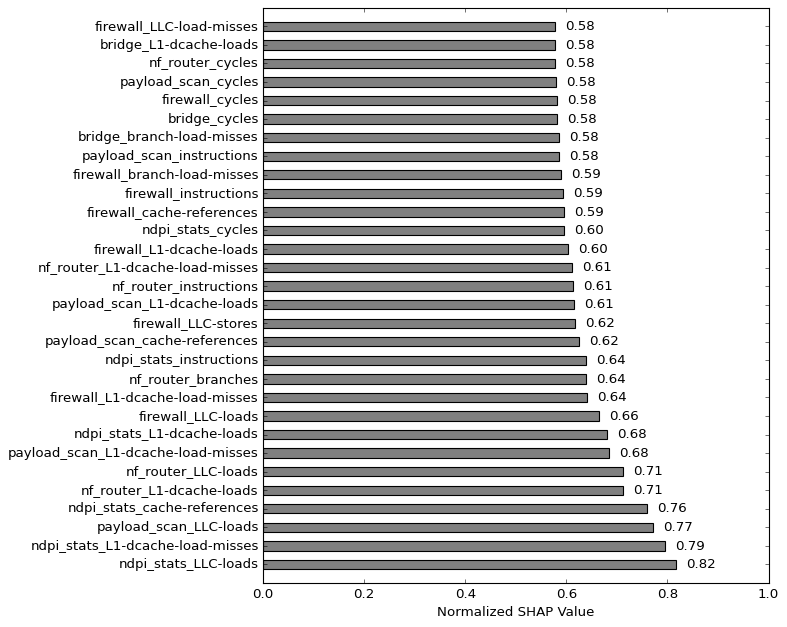

[0.81696238 0.79481655 0.77057671 0.75885072 0.71249617 0.71229257
 0.68347978 0.68010843 0.66455586 0.64108326 0.63869591 0.63782402
 0.62420563 0.61695823 0.61471976 0.6131237  0.61120415 0.60361581
 0.59614057 0.59482305 0.59306878 0.58992711 0.58483016 0.58477886
 0.58196675 0.58112989 0.57945633 0.5779857  0.57705212 0.57677004
 0.57442548 0.57337635 0.56989958 0.55150728 0.54693524 0.53479817
 0.53275743 0.52286072 0.39977287 0.37741622 0.34792403]
[38 22 39 12 26 37 23 27 36 20  5  2 13 31 28  1 21 25 17 10  0  7  3  8
 19 15 18 16 29 30 35  9 11 34  6  4 32 33 24 14 40]


In [52]:
# Normalize the SHAP values to [0, 1]
shap_values_normalized = (shap_values - shap_values.min()) / (shap_values.max() - shap_values.min())

# Create a new DataFrame from the numpy array with the original column names
# (This part is omitted as it was already defined in the previous code)

# Sort the features based on their sensitivity (SHAP values) for the specific data point
sorted_indices = np.argsort(shap_values_normalized[0])[::-1]

# Set the background color of the plot to white
plt.rcParams['figure.facecolor'] = 'white'

# Create a horizontal bar plot of the normalized SHAP values for the specific data point
plt.figure(figsize=(10, 8))  # Increase the figure size

bars = plt.barh(range(30), shap_values_normalized[0][sorted_indices][:30], height=0.5, color='grey')  # Increase bar height
plt.yticks(range(30), np.array(feature_names)[sorted_indices][:30])
plt.xlabel('Normalized SHAP Value')

# Add SHAP values as labels for each bar, avoiding overlapping with bars
for i, bar in enumerate(bars):
    value = shap_values_normalized[0][sorted_indices][i]
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', ha='left', va='center')

# Adjust the x-axis limits to reduce empty space on both ends
plt.xlim(0, 1)  
# Adjust the y-axis limits and margins to reduce the distance to the boundary
plt.ylim(-1, 30)  
plt.margins(y=0.02)  

plt.tight_layout()
plt.show()

print(shap_values_normalized[0][sorted_indices])
print(sorted_indices)
